# Image Classification with Convolutional Networks

## Problem

Image classification refers to classification of image according to its visual content. This can be, for example, retrieving all images which contain object of specific class (such as human, car etc.) As machine learning systems become more complex, image classification algorithm in mmany cases is one of components of more complex algorithms, such as object detection or instance segmentation.

In this lab, we'll explore how to implement from scratch image classification algorithm using MXNet Gluon framework and train it to one of popular image datasets. We'll also use one of pretrained state-of-the-art image classification algorithms [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) and compare algorithms' performance. For training of image classification algorithms in this lab we will implement  two options:
1. **train model on local notebook instance** - this method is implemented in first half of the lab;
2. **train model using Sagemaker Training service** - this method is used in second half of the lab.

## What is Convolutional Neural Networks (CNN)

A **Convolutional Neural Network** (CNN, or ConvNet) is comprised of one or more convolutional layers (often with a subsampling step) and then followed by one or more fully connected layers as in a standard multilayer neural network. The architecture of a CNN is designed to take advantage of the 2D structure of an input image (or other 2D input such as a speech signal). This is achieved with local connections and tied weights followed by some form of pooling which results in translation invariant features. Another benefit of CNNs is that they are easier to train and have many fewer parameters than fully connected networks with the same number of hidden units.

<center><img src='images/cnn.png' width=700></center> 

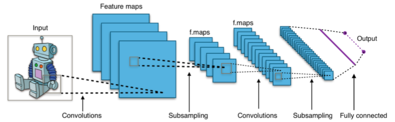

# How to Use This Tutorial¶
You can use this tutorial by executing each snippet of python code in order as it appears in the notebook. An easy way to do so is to click on the "run cell, select below" arrow that is to the left of the "stop" icon in the toolbar. In this tutorial, we will train an CNN on an CIFAR10 dataset which will ultimately produce a neural network that can classify images into 10 classes.


# Prerequisites
- Skills: Familiarity with MXNet, Gluon, Python, Numpy, basics of CNN networks;
- Resource: Sagemaker Notebook with GPU; access to Sagemaker Training service and S3 bucket.

# Part 1. Build your CNN model from scratch

## Dataset Overview

For this lab, we'll use [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which contains 60,000 images with 10 object classes: airplane, car, bird, cat, deer, dog, frog, horse, ship, and truck. Each image has 32x32 dimension with 3 color channels. Each object has exactly one object.

Let's start by loading required modules.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import datetime

import mxnet as mx
import mxnet.ndarray as nd
from mxnet import gluon
from mxnet.gluon import nn, loss, Trainer
from mxnet.gluon.contrib.estimator import estimator
from mxnet.gluon.data import DataLoader, ArrayDataset
from mxnet.gluon.data.vision import transforms

In [ ]:
# Define where to execute computations
device = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

## Data Processing

Data processing is critical for any computer vision problem. There are following common processing techniques:
- data augmentation by creating rotated, flipped, randomly cropped copies from original dataset;
- normalization of image (see details [here](https://en.wikipedia.org/wiki/Normalization_(image_processing)));
- converting images into format compatible with CNN architecture. 

Gluon has built-in **vision.transform**  package wich implements common data transformation. 
Execute code cell below to create transformation pipeline for training dataset and answer following questions:
- Why most of transformations are random? 
- What data augmentation techniques do we use?
- How does it help to improve model's generalization power?

In [ ]:
# Prepare training dataset
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32
    transforms.RandomResizedCrop(32, scale=(0.08, 1.0)),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], # precomputed mean for CIFAR10 dataset across 3 color channels
                         [0.2023, 0.1994, 0.2010]  # precomputed standard deviation for CIFAR10 dataset across 3 color channels
                        )
])

Now, let's prepare test dataset transformation pipeline. Unlike in case of training dataset, we don't use any random transformation to have deterministic result. However, we still need to normalize image to make it more "machine friendly".

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

Gluon provides a convenient way to retrieve CIFAR10 dataset and convert data into DataLoader objects.

In [ ]:
# Batch Size for Each GPU
batch_size = 128
# Number of data loader workers
num_workers = 8

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
test_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Explore CIFAR10 dataset

Execute cells below and familirize with dataset. Could you classify all images? Do you think low dimensionality of images will present a problem for machine learning algorithms?

In [ ]:
# CIFAR10 indexed classes
CIFAR10_LABEL_LIST = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
# Helpfer function to render MXNet NDArray as image
def render_as_image(fig, a, label, index):
    img = a.asnumpy() # convert to numpy array
    img = img.transpose((1, 2, 0))  # Move channel to the last dimension
    #img = img.astype(np.uint8)  # use uint8 (0-255)
    ax = fig.add_subplot(rows, columns, index)
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelsize=0, length = 0)
    ax.title.set_text(str(label))
    plt.imshow(img)

    
# Prepare dataset for demo purposes w/o data augmentation or normalization.
transform_demo = transforms.Compose([transforms.ToTensor()])
demo_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_demo),batch_size=21, shuffle=True, num_workers=num_workers)

# Define parameters of image grid
w = 16
h = 16
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

# Iterate over images and render them in image grid along with class label.
for i in demo_data:
    for j in range(1, columns*rows+1):
        label_index = int(i[1][j].asscalar())
        render_as_image(fig, i[0][j], CIFAR10_LABEL_LIST[label_index], j)
    break

plt.show()

## Build CNN Network

Typical CNN network architecture includes two types of layer blocks:
- **feature extraction block** (or feature extractor) - a sequence of convolutional layers and down sampling (MaxPool) layers;
- **classification block** - a sequence of fully-connected dense layers.

A goal of feature extraction blocks is to learn and "featurize" visual patterns of dataset and pass these visual features to classification block for final classification. In the proposed network architecture below, we have 2 feature extraction blocks followed by classification block.


## LAB INSTRUCTION
Define following variables:
- **num_fc** with **512** - a number of units in classification Dense layer;
- **num_classes** with **len(CIFAR10_LABEL_LIST)** - a number of units in ouput Dense layers.

In [ ]:
# Remove parameters when sending for review
num_fc =           # see instruction above
num_classes =      # see instruction above


def build_net(net): #model from here: https://keras.io/examples/cifar10_cnn/
    with net.name_scope(): 

        # First feature extraction block
        net.add(gluon.nn.Conv2D(channels=32, kernel_size=(3,3), activation='relu'))
        net.add(gluon.nn.Conv2D(channels=32, kernel_size=(3,3), activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=(2,2)))
        net.add(nn.Dropout(0.25))

        # Second feature extraction block        
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=(3,3), activation='relu'))
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=(3,3), activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=(2,2)))
        net.add(nn.Dropout(0.25))
        
        # The Flatten layer collapses all axis, except the first one, into one axis.
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(num_fc, activation="relu"))
        net.add(nn.Dropout(0.5))
        net.add(gluon.nn.Dense(num_classes))
        net.collect_params().initialize(init=mx.init.Xavier(), ctx=device)
    return net


# CNN model has a feed forward network architecture, 
# so we'll use Gluon Sequential block, which stacks layers sequentially one on top of another.
# We use HybridSequential block for performance optimizations during training process.
# More on this: https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/blocks/hybridize.html
custom_net = build_net(nn.HybridSequential()) 

## LAB INSTRUCTION

Let's review our network architecture. Do following:
- Add a new cell by clicking on the **"+"** sign on the tool bar  
- Type **custom_net.summary(nd.ones((128, 3, 32, 32), ctx=device))** in the new cell and run the cell to visualize the network

Answer following questions:
- What are params of Embedding and Dense layers? What happened with layer params during model training?
- Why does Activation and Dropout layers have no any params?

## MXBoard - vizualizing your training process

[MXBoard package](https://github.com/awslabs/mxboard) is a set of APIs for logging MXNet data for visualization in TensorBoard. [Tensorboard](https://www.tensorflow.org/tensorboard) provides the visualization and tooling needed for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- And much more.

In this lab, you'll learn how to visualize basic parameters of training process using MXBoard.

We start from installing required packaged: mxboard and tensorboard.

In [ ]:
# Installing MXboard and Tensorboard
!pip install mxboard
!pip install tensorboard

In [ ]:
# SummaryWriter is base class for writing trianing logs compatible with MXboard/Tensorboard
from mxboard import SummaryWriter

Below, we'll create a custom EventHandler which will allow feed training metrics such as loss and accuracy to MXBoard in real-time.

In [ ]:
# Create custom Gluon event handler which will write training progress and metrics to MXboard
from mxnet.gluon.contrib.estimator.event_handler import LoggingHandler, TrainBegin, TrainEnd, EpochEnd, BatchBegin, BatchEnd, EpochBegin


class BoardLoggingHandler(TrainBegin, TrainEnd, EpochEnd, BatchBegin, BatchEnd):
    """
    Custom EventHandler to feed training logs to MXboard.
    Params:
    - summary_writer - MXBoard SummaryWriter object;
    - model_tag - a string param to differentiate multiple models/trainings
    """
    def __init__(self, summary_writer, model_tag=''):
        super(BoardLoggingHandler, self).__init__()
        self.sw = summary_writer
        self.tag=model_tag
        self.epoch = 1 # epoch counter
        
    def train_begin(self, estimator, *args, **kwargs):
        print("Training loss and accuracy will be available in MXboard")
        
    def epoch_end(self, estimator, *args, **kwargs):

        # iterate over metrics and write to mxboard accuracy and loss only
        for metric in estimator.train_metrics:
            if isinstance(metric, mx.metric.Loss):
                loss_name, loss_val = metric.get()
                self.sw.add_scalar(tag='{}_train_loss'.format(self.tag), value=loss_val, global_step=self.epoch)
                
            if isinstance(metric, mx.metric.Accuracy):
                acc_name, acc_val = metric.get()
                self.sw.add_scalar(tag='{}_train_accuracy'.format(self.tag), value=acc_val, global_step=self.epoch)
        
        self.epoch += 1

## LAB INSTRUCTIONS

## Start Tensorboard

Perform steps below to start Tensorboard service:
1. Get the current notebook directory by running cell below (with `pwd` Linux command);
2. Open separate Terminal window in your Jupyter notebook;
3. Switch to correct Conda virtual env by issuing in Terminal window `source activate mxnet_p36`
4. Navigate to folder (see step 1) using `cd {root_dir}`
5. Start TensorBoard in the same Terminal window `tensorboard --port 6006 --logdir logs`

Ensure that there is only one Tensorboard process running on specified port. You can kill previous Tensorboard process from Terminal window. See for details https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server


In [ ]:
# Getting current root dir where MXBoard logs will be stored.
!pwd

Now, let's open Tensorboard in directly Jupyter cell. Execute cell below. You training progress now will be available on the dashboard in real-time.

**Note!** Enter Url of your notebook instances below.

In [ ]:
from IPython.display import IFrame

url = 'https://mirror-repo.notebook.us-east-2.sagemaker.aws/proxy/6006/'
IFrame(url, width=1200, height=800)

## Training CNN Model

## LAB INSTRUCTION

- Enter **25** as the value for variable **num_epoch**  - this is number of epochs to train the model
- Enter **0.0001** as the value for variable **learning_rate** - this parameters defines how much we are adjusting weights of our network during training
- Enter **mx.optimizer.RMSProp(learning_rate=learning_rate, gamma1=1e-6)** as the value for variable **optimizer** - this is the optimizer for updating the weights.
- Enter **[mx.metric.Accuracy(), mx.metric.Loss()]** as the value for variable **metric** - this is the performance evaluation metric

In [ ]:
# training parameteres 
num_epoch =        # follow instruction above 
learning_rate =    # follow instruction above 
optimizer =        # follow instruction above
metrics =          # follow instruction above

# Softmax is a classifier, and cross-entropy loss is used as the loss function by default. 
# mxnet.gluon.loss.SoftmaxCrossEntropyLoss includes softmax function. 
# Therefore, we didn't include "softmax" activation into output Dense layer above.
softmax_cross_entropy = loss.SoftmaxCrossEntropyLoss(sparse_label=True) 

# Hybredize method converts imperative Gluon code into symbolic MXNet computational graphs which are much faster.
# This allows users to use simple impreative Gluon APIs without any negative performance impact.
# Read further about MXNet Hybredize here: https://beta.mxnet.io/guide/packages/gluon/hybridize.html
custom_net.hybridize() 

# Define the estimator, by passing to it the model, loss function, metrics, trainer object and context
trainer = Trainer(custom_net.collect_params(), optimizer)

# Prepare for writing MXboard logs
sw = SummaryWriter(logdir='logs', flush_secs=5)
board_logging_handler = BoardLoggingHandler(sw, 'CNN_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

est = estimator.Estimator(net=custom_net,
                          loss=softmax_cross_entropy,
                          val_metrics=metrics,
                          trainer=trainer,
                          context=device)

est.fit(train_data=train_data, val_data=test_data, epochs=num_epoch, 
                         event_handlers=[board_logging_handler])

sw.close() # closing MXBoard SummaryWriter object

## Model Evaluation
Let's review some of the model predictions.

Answer following questions:
- Is model accuracy on test dataset comparable to model accuracy on training and validation datasets? 
- How can you explain difference?

In [ ]:
# Let's get a few samples random samples and evaluate them
for data, labels in test_data: 
    eval_data = data
    eval_labels = labels
    
# Convert evaluation data and labels into MXNet NDArray class as Gluon model expects it.
eval_labels = mx.nd.array(eval_labels, ctx=device)
eval_data = mx.nd.array(eval_data, ctx=device)

# Get prediction using trained model and doing one pass forward using net(x) method
predictions = custom_net(eval_data)
# Convert float model output to binary values: 0 (negative) or 1 (positive)
predictions = predictions.argmax(axis=1)

# Create MXnet Metric object to evaluate accuracy of predictions.
metric = mx.metric.Accuracy(axis = 0)
metric.update(preds = predictions, labels = eval_labels)

# Define parameters of image grid
w = 10
h = 10
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 4

# Iterate over predictions and render images
for i in range(columns*rows):
    pred_index = int(predictions[i].asscalar())
    render_as_image(fig, eval_data[i], "pred="+CIFAR10_LABEL_LIST[pred_index], (i+1))

plt.show()

# Part 2. Training using Sagemaker Training service

## Finetuning pre-trained ResNet network

Clearly, our CNN network from example above has a room for improvement and at current state is underfitting. Let's compare its accuracy with state-of-the-art [ResNet network](https://arxiv.org/abs/1512.03385).  This network architecture was developed in 2015 and since then has become a default choice for many image classification tasks. ResNet architecture introduced several unique features such as skip connections and batch normalizations.

Training complex models such as ResNet has two critical requirements: large amounts of data and significant compute resources for model training. Therefore, it's a common practice to re-use previously trained models and fine tune weights for specific problem. In case of image classification algorithms, one can use trained feature extraction blocks and only train small classifier block which will be unique for specific problem at hand.

MXNet has built-in ResNet model as part of `gluon.model_zoo package` which we'll use in our training.

## Sagemaker Training overview

You can use Amazon SageMaker to train and deploy a model using custom MXNet code. The [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/) MXNet estimators and models and the Amazon SageMaker open-source MXNet container make writing a MXNet script and running it in Amazon SageMaker easier.

Training your model using Sagemaker Training service includes following key steps:
1. User defines basic configuration of training job (S3 buckets, IAM role, Sagemaker session);
2. User defines training script which will be executed at training time;
3. User starts the training job with specific hyperparameters, training container, instance types, number of training nodes, etc;
4. Sagemakers creates training cluster with specified parameters;
5. Sagemaker starts training script on each training node and provide customer-defined hyperparameters;
6. During training, Sagemaker sends training logs to Amazon Cloudwatch logs and metrics;
6. When training job completed, Sagemaker updates training job status and uploads trained model and training job output to specified S3 buckets.

<center><img src='images/sm_training.png'  style="width: 700px;"><br>
    Model training using Sagemaker (<a href=https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html>source</a>)
    <br><br>
</center> 


## Configuring Sagemaker training job
Cells below make necessary imports and provide initial configuration of Sagemaker training service. Please review them and update them in case if default values doesn't work for you.

In [29]:
# necessary import
import boto3
import os
import numpy as np
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet

role = get_execution_role() # getting IAM role of your Sagemaker Notebook

In [30]:
# Define Sagemaker Training service configuration

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket() # you can provide here a specific S3 bucket if you prefer. Otherwise, default bucket will be used.
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
# Define S3 bucket prefixes for input and output of training job
prefix_input = 'mxnet-resnet-input'
prefix_output = 'mxnet-resnet-ouput'
data_dir = "mnist"

## Preparing Sagemaker training script


To run training on Sagemaker Training service, you need to supply a training script which will be executed on remote training cluster. Users can tune parameters of training using Sagemaker hyperparameters object. Training will be started on training nodes using following command: 

`python training_script.py --hyperparameter1 Value1 --hyperparameter2 Value2 .... -- hyperparameterN ValueN`

Review prepared training script below using `pygmentize` command and pay attention to following code blocks:
- `if __name__ == "__main__"` - this code block is executed when we run our training code as script via `python code.py` command. In this block we parse training hyperparameter and call `train()` method;
- `train()` method implements main training logic;
- `_get_data_loaders()` and `_get_resnet_model()` are internal methods to encapsulate logic of getting data loaders and building the model.



In [ ]:
!pygmentize lab_2_entry_point/train.py

## Define Sagemaker Hyperparameters

Hyperparameters are parameters that are set before a machine learning model begins learning. These parameters typically define key characteristics of your training process such as parameters of your model, loss function, optimizers etc. Sagemaker doesn't restrict what parameteres you can define and provides a convenient mechanism for configuration using python dictionary object.

## LAB INSTRUCTION
Define training hyperparameters below as follows:
- **batch-size** with **128**;
- **num-epochs** with **10**;
- **learning-rate** with **0.0001**;
- **num-classes** with **10**.

In [ ]:
hyperparameters = {
    "batch-size" :     , # follow instructions above
    "num-epochs" :     , # follow instructions above
    "learning-rate" :  , # follow instructions above
    "num-classes" :      # follow instructions above
}

Now, let's submit our training job using MXNet class from Sagemaker Python SDK. 

## LAB INSTRUCTION
Define training parameters:
- **train_instance_count** with **1** - a number of instances in Sagemaker training cluster;
- **train_instance_type** with **ml.p2.xlarge** - type of instances used at training; p2 family comes with dedicated GPU chip.

In [ ]:
est = MXNet("train.py", # training script
            source_dir="lab_2_entry_point", # directory where training script is stored
            role=role,  # Sagemaker role
            train_instance_count=     , # follow instructions above
            train_instance_type=      , # follow instructions above
            hyperparameters = hyperparameters,
            framework_version="1.6.0", # version of MXNet framework
            py_version="py3" # version of Python interpreter
           )

# Start training job
est.fit()

## Compare results: model from scratch VS pre-trained ResNet
Now that you trained two CNN model architectures: simple CNN which we created from scratch and fine-tuning pre-trained ResNet model, answer following questions:
- which model is more accurate? 
- how does model complexity influence training time (you can compare time to complete single epoch)?
- what approach is more practical in your opinion?

## Summary of Lab
During this lab you learned following:
- how to pre-process image datasets using MXNet builtin transformations;
- how to train models on Sagemaker Notebook instances and using Sagemaker Training service;
- how to build CNN model from scratch using Gluon layers and evaluate its performance;
- how to fine tune pretrained state-of-art models.